# Image Classification 과제
> 인공지능 스터디 두 번째 과제에 오신 것을 환영합니다! 강의를 들으면서 배운 다양한 지식들을 실습을 통해서 활용해볼 시간을 가질 것입니다!

#### 🐙 강의에서 배운 이미지 분류(Image Classification) 작업을 직접 실습을 통해 훈련(Train)부터 테스트(Test)까지 진행해보아요. 함께 시작해봅시다! 😊

#### 👨‍💻 <font color='green'><b>[ 코딩 ]</b></font> 이미지 분류기 학습하기
```python
🐙
코드를 실행하면서 분류기를 학습해보아요
```


# 분류기(Classifier) 학습하기

지금까지 어떻게 신경망을 정의하고, 손실을 계산하며 또 가중치를 갱신하는지에
대해서 배웠습니다.

이제 아마도 이런 생각을 하고 계실텐데요,

## 데이터는 어떻게 하나요?

일반적으로 이미지나 텍스트, 오디오나 비디오 데이터를 다룰 때는 표준 Python 패키지를
이용하여 NumPy 배열로 불러오면 됩니다. 그 후 그 배열을 ``torch.*Tensor`` 로 변환합니다.

-  이미지는 Pillow나 OpenCV 같은 패키지가 유용합니다.
-  오디오를 처리할 때는 SciPy와 LibROSA가 유용하고요.
-  텍스트의 경우에는 그냥 Python이나 Cython을 사용해도 되고, NLTK나 SpaCy도
   유용합니다.

특별히 영상 분야를 위한 ``torchvision`` 이라는 패키지가 만들어져 있는데,
여기에는 ImageNet이나 CIFAR10, MNIST 등과 같이 일반적으로 사용하는 데이터셋을 위한
데이터 로더(data loader), 즉 ``torchvision.datasets`` 과 이미지용 데이터 변환기
(data transformer), 즉 ``torch.utils.data.DataLoader`` 가 포함되어 있습니다.

이러한 기능은 엄청나게 편리하며, 매번 유사한 코드(boilerplate code)를 반복해서
작성하는 것을 피할 수 있습니다.

오늘은 CIFAR10 데이터셋을 사용합니다. 여기에는 다음과 같은 분류들이
있습니다: '비행기(airplane)', '자동차(automobile)', '새(bird)', '고양이(cat)',
'사슴(deer)', '개(dog)', '개구리(frog)', '말(horse)', '배(ship)', '트럭(truck)'.
그리고 CIFAR10에 포함된 이미지의 크기는 3x32x32로, 이는 32x32 픽셀 크기의 이미지가
3개 채널(channel)의 색상으로 이뤄져 있다는 것을 뜻합니다.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


## 이미지 분류기 학습하기

다음과 같은 단계로 진행해보겠습니다:

1. ``torchvision`` 을 사용하여 CIFAR10의 학습용 / 시험용 데이터셋을
   불러오고, 정규화(nomarlizing)합니다.
2. 합성곱 신경망(Convolution Neural Network)을 정의합니다.
3. 손실 함수를 정의합니다.
4. 학습용 데이터를 사용하여 신경망을 학습합니다.
5. 시험용 데이터를 사용하여 신경망을 검사합니다.

### 1. CIFAR10을 불러오고 정규화하기

``torchvision`` 을 사용하여 매우 쉽게 CIFAR10을 불러올 수 있습니다.

각자의 커널 가상환경에 필요한 torch와 torchvision을 설치합니다. 

In [4]:
!pip install torch torchvision

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

torchvision 데이터셋의 출력(output)은 [0, 1] 범위를 갖는 PILImage 이미지입니다.
이를 [-1, 1]의 범위로 정규화된 Tensor로 변환합니다.

<div class="alert alert-info"><h4>Note</h4><p>만약 Windows 환경에서 BrokenPipeError가 발생한다면,
    torch.utils.data.DataLoader()의 num_worker를 0으로 설정해보세요.</p></div>



### Dataset
```python
데이터 셋으로는 CIFAR10 데이터셋을 사용합니다.
필요한 데이터셋이니 다운로드받아야합니다. 

🐙
이미지 분류를 위한 카테고리가 다음과 같이 10개가 있어 CIFAR10 데이터셋인가보군요
```

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


재미삼아 학습용 이미지 몇 개를 보겠습니다.



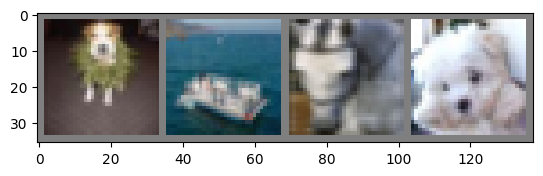

dog   ship  horse dog  


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

어떤 이미지가 있으며 어떤 정답 라벨을 가지고 있는지 확인해보았나요?




### 2. 합성곱 신경망(Convolution Neural Network) 정의하기
CNN에 대해 수업시간에 학습했던 내용들을 복습하며 각각이 어떤 역할을 하는 코드인지 복습해봅시다.  

Conv2d, MaxPool2d, Linear 함수가 어떤 역할일까요?
relu는 활성화함수의 일종인것같죠?

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### nn.Conv2d(3, 6, 5)는 PyTorch에서 2D 합성곱 층(Convolutional Layer)을 정의하는 부분입니다. 각 매개변수의 의미는 다음과 같습니다.

첫 번째 인자 (3): 입력 채널의 수

이는 입력 이미지의 채널 수를 의미합니다.
여기서는 3으로, RGB 컬러 이미지를 입력으로 받는다는 것을 나타냅니다.


두 번째 인자 (6): 출력 채널의 수

이는 이 합성곱 층에서 생성할 특징 맵(feature map)의 개수입니다.
즉, 6개의 서로 다른 필터(커널)를 적용하여 6개의 출력 채널을 만듭니다.


세 번째 인자 (5): 커널(필터)의 크기

이는 5x5 크기의 정사각형 필터를 사용한다는 의미입니다.

### 3. 손실 함수와 Optimizer 정의하기
손실 함수로는 1주차 시간에 잠깐 배웠던 multi-class image classification에서 쓰였던 교차 엔트로피 손실(Cross-Entropy loss)를 사용하며
Optimizer는 아직 학습하지 않았지만 모멘텀(momentum) 값을 갖는 SGD를 사용해봅시다.



In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. 신경망 학습하기

이제 재미있는 부분이 시작됩니다.
단순히 데이터를 반복해서 신경망에 입력으로 제공하고, 최적화(Optimize)만 하면
됩니다.



In [10]:
for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.206
[1,  4000] loss: 1.867
[1,  6000] loss: 1.674
[1,  8000] loss: 1.587
[1, 10000] loss: 1.524
[1, 12000] loss: 1.468
[2,  2000] loss: 1.418
[2,  4000] loss: 1.359
[2,  6000] loss: 1.354
[2,  8000] loss: 1.324
[2, 10000] loss: 1.309
[2, 12000] loss: 1.319
Finished Training


학습한 모델을 저장해보겠습니다:



In [11]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


### 5. 시험용 데이터로 신경망 검사하기

지금까지 학습용 데이터셋을 2회 반복하며 신경망을 학습시켰습니다.
신경망이 전혀 배운게 없을지도 모르니 확인해봅니다.

신경망이 예측한 출력과 진짜 정답(Ground-truth)을 비교하는 방식으로 확인합니다.
만약 예측이 맞다면 샘플을 '맞은 예측값(correct predictions)' 목록에 넣겠습니다.

첫번째로 시험용 데이터를 좀 보겠습니다.



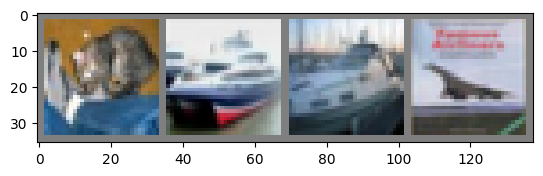

GroundTruth:  cat   ship  ship  plane


In [12]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

이제, 저장했던 모델을 불러오도록 하겠습니다 (주: 모델을 저장하고 다시 불러오는
작업은 여기에서는 불필요하지만, 어떻게 하는지 설명을 위해 해보겠습니다):



In [13]:
net = Net()
net.load_state_dict(torch.load(PATH))

/var/folders/bp/5lpnj49j0_1bj1wjw2f3nfrm0000gn/T/ipykernel_13459/238682776.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

좋습니다, 이제 이 예제들을 신경망이 어떻게 예측했는지를 보겠습니다:



In [14]:
outputs = net(images)

출력은 10개 분류 각각에 대한 값으로 나타납니다. 어떤 분류에 대해서 더 높은 값이
나타난다는 것은, 신경망이 그 이미지가 해당 분류에 더 가깝다고 생각한다는 것입니다.
따라서, 가장 높은 값을 갖는 인덱스(index)를 뽑아보겠습니다:



In [15]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  ship  ship  car   ship 


결과가 괜찮아보이네요.

그럼 전체 데이터셋에 대해서는 어떻게 동작하는지 보겠습니다.



In [16]:
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 53 %


(10가지 분류 중에 하나를 무작위로) 찍었을 때의 정확도인 10% 보다는 나아보입니다.
신경망이 뭔가 배우긴 한 것 같네요.

그럼 어떤 것들을 더 잘 분류하고, 어떤 것들을 더 못했는지 알아보겠습니다:



In [17]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 58.2 %
Accuracy for class: car   is 64.6 %
Accuracy for class: bird  is 49.2 %
Accuracy for class: cat   is 18.7 %
Accuracy for class: deer  is 23.9 %
Accuracy for class: dog   is 43.6 %
Accuracy for class: frog  is 78.6 %
Accuracy for class: horse is 59.9 %
Accuracy for class: ship  is 68.5 %
Accuracy for class: truck is 69.3 %


### 🎉🎉🎉 2주차 과제 완료! 🎉🎉🎉
```python
🐙
여러분 모두 수고 했어요!! 추석 과제를 complete한 당신에게 행운을 드립니다. 다음 미션은 선택 제출입니다.
```

``` python 
📝 미션:

1. 강의록 p42와 유사한 CNN 구조 도식을 손으로 그리기 (발그림이어도 괜찮)
2. 위에서 정의한 class Net(nn.Module)의 총 학습 가능한 파라미터 개수 구하기 (정답이 맞아야함. 1회 도전만 가능)


🏆 보상:

정답을 맞히고 손그림 도식과 계산 과정을 디스코드 DM으로 인증한 당신에게 커피 쿠폰을 드립니다! (멘토 사비로 증정, 단 선착순 5인에게만 해당)

🕒 기한: [24.10.01]
📬 제출: DM으로 인증샷 전송

자, 여러분의 뇌를 깨워 CNN을 정복하고 커피를 받아가세요. 행운을 빕니다! 🍀
```